In [2]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import setGPU
from importlib import reload

import data_prep.data_reader as dare
import data_prep.preprocessing as prep
import models.graph_nn as grap
import data_analysis.plotting as plott

setGPU: Setting GPU to: 5


In [3]:
%load_ext autoreload
%autoreload 2

# read in data

In [4]:
input_dir = '/eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1/qcd/merged/'
file_name = 'flat_scouting_2_numEvent500_event.h5'
file_path = os.path.join(input_dir, file_name)

In [5]:
samples = dare.read_event_samples_from_file(file_path)

In [6]:
#samples = samples[:2000]

In [7]:
samples.shape

(212500, 52, 6)

In [8]:
features_names = ['px', 'py', 'pz', 'pt', 'eta', 'phi']

In [9]:
# mask events with ojects having pt > 13000
reload(prep)
pt_idx = features_names.index('pt')
pz_idx = features_names.index('pz')
samples = prep.mask_events(samples, [pt_idx, pz_idx], [5e3, 5e3])

In [11]:
batch_size = 128
samples = samples[:batch_size*int(1e3)]
print(samples.shape)

(128000, 52, 6)


## normalize

In [12]:
samples = prep.normalize_features_event_based(samples)

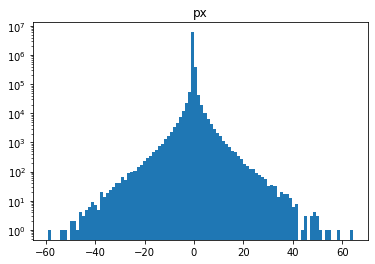

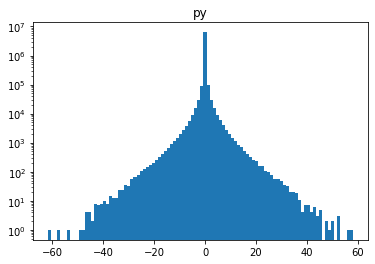

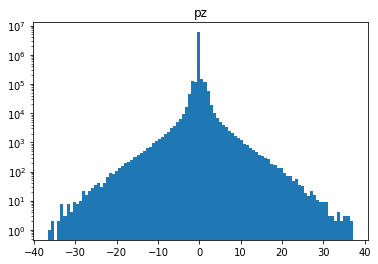

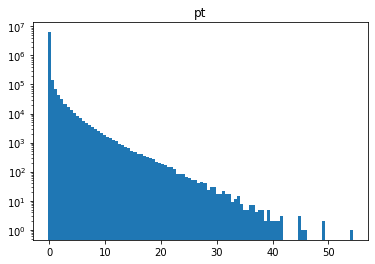

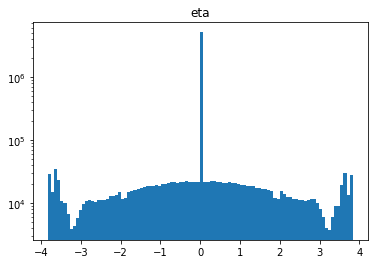

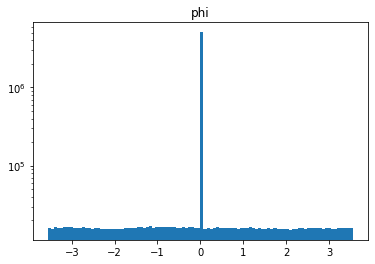

In [13]:
for i in range(samples.shape[2]):
    plt.figure()
    _ = plt.hist(samples[:,:,i].flatten(), bins=100)
    plt.title(features_names[i])
    plt.yscale('log')

# prepare input for model

In [14]:
nodes_n = samples.shape[1]
feat_sz = samples.shape[2]

In [15]:
batch_size = 128

In [16]:
A = prep.make_adjacencies(samples, pt_idx=pt_idx)
A_tilde = prep.normalized_adjacency(A)

/eos/home-k/kiwoznia/dev/ada_hackaton_2021/scouting_fatjet_graph/data_prep/preprocessing.py:64: RuntimeWarning: divide by zero encountered in power
  D = np.nan_to_num(np.power(D,-0.5), posinf=0, neginf=0) # normalize (**-(1/2))


# build and train model

In [17]:
gnn = grap.GraphVariationalAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True)

In [18]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1), tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, verbose=1)]
gnn.fit((samples, A_tilde), A, epochs=100, batch_size=128, validation_split=0.25, callbacks=callbacks)

Epoch 1/100
750/750 [==============================] - 25s 34ms/step - loss: 0.9592 - loss_reco: 0.8529 - loss_latent: 0.1063 - val_loss: 0.7307 - val_loss_reco: 0.7146 - val_loss_latent: 0.0161
Epoch 2/100
750/750 [==============================] - 25s 33ms/step - loss: 0.7312 - loss_reco: 0.7151 - loss_latent: 0.0162 - val_loss: 0.7313 - val_loss_reco: 0.7151 - val_loss_latent: 0.0163
Epoch 3/100
750/750 [==============================] - 24s 33ms/step - loss: 0.7313 - loss_reco: 0.7151 - loss_latent: 0.0162 - val_loss: 0.7331 - val_loss_reco: 0.7167 - val_loss_latent: 0.0164
Epoch 4/100
750/750 [==============================] - 24s 33ms/step - loss: 0.7312 - loss_reco: 0.7150 - loss_latent: 0.0162 - val_loss: 0.7307 - val_loss_reco: 0.7147 - val_loss_latent: 0.0160
Epoch 5/100
750/750 [==============================] - 25s 34ms/step - loss: 0.7312 - loss_reco: 0.7150 - loss_latent: 0.0162 - val_loss: 0.7284 - val_loss_reco: 0.7123 - val_loss_latent: 0.0161
Epoch 6/100
750/750 [====

## predict background

In [19]:
input_dir_qcd_test = '/eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1/qcd/merged'
file_name_qcd_test = 'flat_scouting_3_numEvent500_event.h5'
file_path_qcd_test = os.path.join(input_dir_qcd_test, file_name_qcd_test)

In [30]:
samples_qcd_test = dare.read_event_samples_from_file(file_path_qcd_test)
samples_qcd_test = prep.normalize_features_event_based(samples_qcd_test)
samples_qcd_test = samples_qcd_test[:5000]
print(samples_qcd_test.shape)

(5000, 52, 6)


In [31]:
A_qcd_test = prep.make_adjacencies(samples_qcd_test, pt_idx=pt_idx)
A_qcd_test_tilde = prep.normalized_adjacency(A_qcd_test)

In [32]:
z, z_mean, z_log_var, A_pred = gnn((samples_qcd_test, A_qcd_test_tilde))
#A_qcd_reco = (tf.nn.sigmoid(A_qcd_pred) > 0.5).numpy().astype('int')

In [33]:
loss_qcd = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_qcd_test, A_pred), axis=(1,2)).numpy()

## predict signal

In [34]:
# signal dict
signal_dict = {
    
    'Zprime1000' : 'ZprimeToZH_MZprime1000_MZ50_MH80_narrow',
    'Graviton' : 'BulkGraviton_hh_GF_HH',
    'SMS' : 'SMS-T1qqqq'
    
}

input_dir_signal = '/eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1'

In [35]:
signal_losses = []

for sig_id in signal_dict.keys():
    
    # read signal files
    file_num = np.random.randint(9)
    file_name = 'flat_scouting_' + str(file_num) + '_numEvent500_event.h5'
    file_path_signal = os.path.join(input_dir_signal, signal_dict[sig_id], 'merged', file_name)
    print('predicting ', file_path_signal)
    samples_signal_test = dare.read_event_samples_from_file(file_path_signal)
    
    # preprocess
    samples_signal_test = prep.mask_events(samples_signal_test, [pt_idx, pz_idx], [5e3, 5e3])
    samples_signal_test = prep.normalize_features_event_based(samples_signal_test)
    samples_signal_test = samples_signal_test[:10000]
    print(samples_signal_test.shape)
    
    # make adjacencies
    A_signal_test = prep.make_adjacencies(samples_signal_test, pt_idx=pt_idx)
    A_signal_test_tilde = prep.normalized_adjacency(A_signal_test)
    
    # run inference
    
    z, z_mean, z_log_var, A_signal_pred = gnn((samples_signal_test, A_signal_test_tilde))
    #A_signal_reco = (tf.nn.sigmoid(A_signal_pred) > 0.5).numpy().astype('int')
    loss_signal = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_signal_test, A_signal_pred), axis=(1,2)).numpy()
    signal_losses.append(loss_signal)

predicting  /eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1/ZprimeToZH_MZprime1000_MZ50_MH80_narrow/merged/flat_scouting_7_numEvent500_event.h5
(7000, 52, 6)
predicting  /eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1/BulkGraviton_hh_GF_HH/merged/flat_scouting_5_numEvent500_event.h5
(10000, 52, 6)
predicting  /eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1/SMS-T1qqqq/merged/flat_scouting_8_numEvent500_event.h5
(10000, 52, 6)


# plot loss distributions and ROC

In [36]:
loss_qcd.shape
print(min(loss_qcd))

0.7037911


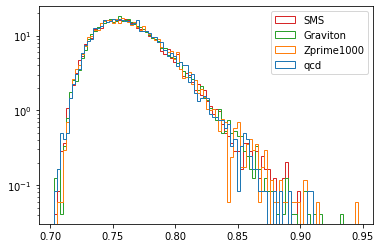

In [42]:
_ = plt.hist([loss_qcd.flatten(), *signal_losses], bins=100, label=['qcd']+list(signal_dict.keys()), histtype='step', density=True)
#plt.xlim(min(loss_qcd), max(loss_qcd))
plt.yscale('log')
plt.legend()

In [38]:
print(min(loss_qcd), max(loss_qcd))

0.7037911 0.9078283


In [39]:
print(min(loss_signal), max(loss_signal))

0.70357007 0.89999044


In [40]:
len(signal_losses)

3

/eos/home-k/kiwoznia/dev/ada_hackaton_2021/scouting_fatjet_graph/data_analysis/plotting.py:80: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-k/kiwoznia/dev/ada_hackaton_2021/scouting_fatjet_graph/data_analysis/plotting.py:80: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-k/kiwoznia/dev/ada_hackaton_2021/scouting_fatjet_graph/data_analysis/plotting.py:80: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


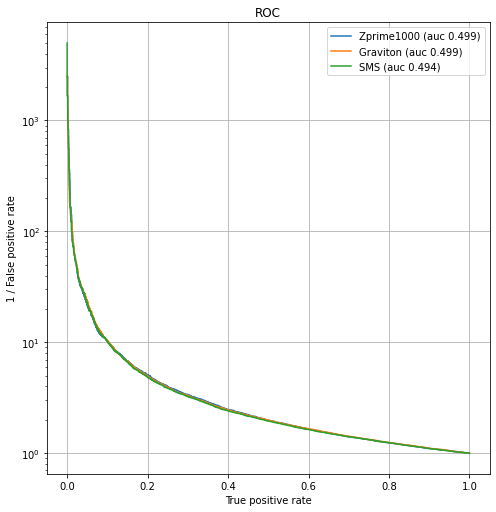

[0.49881040000000004, 0.49920401999999997, 0.49367427]

In [44]:
plott.plot_roc([loss_qcd]*3, signal_losses, legend=list(signal_dict.keys()), log_x=False)